## Intializing stuff

In [1]:
!pwd

/user/m44/ondemand/cse546-rl/assignment1


In [2]:
!which python

/projects/academic/courses/cse546s23/m44/anaconda3/bin/python


In [30]:
import pickle
import pygame
import numpy as np
from tqdm import tqdm
from typing import List, Any

from gymnasium import Env
from gymnasium import spaces
from gymnasium.utils import env_checker

In [31]:
# Display set up
import os
import time
import math
import hashlib
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output


os.environ["SDL_VIDEODRIVER"] = "dummy"

## Define the Agent

### Q-Learning

In [32]:
class QLearningAgent:
  def __init__(self, env: Env, dynamic: bool = False, doubleq: bool = False):
    """
    Args:
      env (Env): The environment the agent should act in.
      doubleq (bool): Whether to use double Q-Learning.
    """
    # Intialize Q-Table
    self.env = env
    self.dynamic = dynamic
    self.doubleq = doubleq

    num_actions = env.action_space.n

    env.reset(seed=88)

    # To allow usage of this agent with the stock trading env
    if isinstance(env.observation_space, spaces.Dict):
      num_states = len(env.states.flatten())
      if dynamic:
        num_states *= self._get_num_situations(np.count_nonzero(env.states))
        self._indexer(num_states)
    else:
      num_states = env.observation_space.n

    # Intialize 2 Q tables if `doubleq` is True
    if doubleq: q_table_shape = (2, num_states, num_actions)
    else: q_table_shape = (num_states, num_actions)

    self._q_table = np.zeros((
      q_table_shape
    ))

    if doubleq:
      self.mean_q_table = self.q_table.mean(axis=0)

  def reset(self):
    self._q_table = np.zeros(self._q_table.shape)
    if self.doubleq:
      self.mean_q_table = self.q_table.mean(axis=0)

  @classmethod
  def _get_num_situations(cls, rewards):
    # Returns game situation count for games with disappearing rewards
    # and goals that can only be reached after all the rewards are collected.
    situations = 0
    for i in range(0, rewards+1):
        situations += math.comb(rewards,i)
    return situations

  def _indexer(self, num_states):
    states = self.env.states.flatten()
    rwd_indices = np.flatnonzero(states).tolist()

    q_table_indices = list(range(num_states))

    self._index_map = {}
    for pos in tqdm(range(len(states)), desc='Indexing States'):
      # Loop over all the situations
      for r in range(0, np.count_nonzero(states)+1):
        for indices in combinations(rwd_indices, r):
          # Define the situation
          sit = states.copy()
          for idx in indices:
            sit[idx] = 0.

          m = hashlib.sha256()
          m.update(bytes(pos)+sit.tobytes())
          # Map a q_table state to the situation
          self._index_map[m.hexdigest()] = q_table_indices.pop(0)

  @property
  def q_table(self) -> np.ndarray:
    return self._q_table

  @q_table.setter
  def q_table(self, path_to_q_table: str):
    with open(path_to_q_table, 'rb') as f:
      q_table = pickle.load(f)

    # Check if the table is compatible
    if self.q_table.shape != q_table.shape:
      raise ValueError("Trying to load incompatible Q-Table.")

    self._q_table = q_table

    # Initialize mean table if using doubleq
    if self.doubleq:
      self.mean_q_table = self.q_table.mean(axis=0)

  def greedy_policy(self, state: int):
    if self.doubleq:
      # Choose the best action after taking the mean value of
      # the actions accross both tables.
      return self.mean_q_table[state].argmax()

    else: return self.q_table[state].argmax()

  def ep_greedy_policy(self, state, epsilon):
    random_num = self.env.np_random.uniform(0, 1)

    if random_num > epsilon:
      return self.greedy_policy(state)

    else:
      return self.env.action_space.sample()

  def _get_state_idx(self, observation: Any) -> int:
    """Helper func to allow the same Agent to be used with the stock
    prediction env.
    """
    if isinstance(observation, dict): state = observation['agent']
    else: state = observation

    # Convert 2-d state index to flat index
    # flat_idx = curr_row*num_cols+curr_col
    if isinstance(state, np.ndarray): 
      state = state[0] * self.env.size + state[1]
    else:
      return state

    if not self.dynamic: return state

    # Get dynamic index
    sit = observation['reward']
    m = hashlib.sha256()
    m.update(bytes(state)+sit.tobytes())
    return self._index_map[m.hexdigest()]

  def step(self, observation):
    state = self._get_state_idx(observation)
    return self.greedy_policy(state)

  def save_pretrained(self, path_to_q_table: str):
    with open(path_to_q_table, 'wb') as f:
      pickle.dump(self.q_table, f)


## Define the Trainers

### Q-Learning Trainer

In [33]:
class QLearningTrainer:
    def __init__(self, agent: QLearningAgent):
        self.agent = agent

    def train(
        self,
        num_episodes: int = 10**5,
        lr: float = .4,
        gamma: float = .9,
        ep_min: float = .08,
        ep_max: float = 1.,
        decay_rate: float = .0008,
        quiet: bool = False
    ) -> List[float]:
        """Train the agent

        Args:
        num_episodes (int, optional): Defaults to 10**5.
        lr (float, optional): The learning rate. Defaults to .4.
        gamma (float, optional): The discount factor. Defaults to .9.
        ep_min (float, optional): Min exploration probability. Defaults to .08.
        ep_max (float, optional): Max exploration probability. Defaults to 1.
        decay_rate (float, optional): Epsilon decay rate. Defaults to .0008.

        Returns:
        List[float]: Reward earned in every episode.
        """
        reward_history: List[float] = list()
        for episode in tqdm(range(num_episodes), desc='Train Episode', disable=quiet):
            epsilon = ep_min + (ep_max-ep_min)*np.exp(-decay_rate*episode)

            total_reward = 0
            obs, _ = self.agent.env.reset(seed=88)
            state = self.agent._get_state_idx(obs)
            terminated, truncated = False, False

            # Run the episode
            while not (terminated or truncated):
                action = self.agent.ep_greedy_policy(state, epsilon)

                obs, reward, terminated, truncated, _ = self.agent.env.step(action)
                new_state = self.agent._get_state_idx(obs)

                total_reward += reward

                # Update the Q table
                next_state_qvalue = self.agent.q_table[new_state].max()

                self.agent.q_table[state, action] += lr * \
                (reward+gamma*next_state_qvalue-self.agent.q_table[state, action])

                state = new_state

            reward_history.append(total_reward)

        return reward_history

    def evaluate(self, num_episodes: int = 10**2, quiet: bool = False) -> List[float]:
        """Evaluate the agent

        Args:
            num_episodes (int): Defaults to 10**2.

        Returns:
            List[float]: Reward earned in every episode.
        """
        reward_history: List[float] = list()
        for _ in tqdm(range(num_episodes), desc='Eval Episode: ', disable=quiet):
            total_reward = 0
            obs, _ = self.agent.env.reset(seed=88)
            terminated, truncated = False, False

            # Run the episode
            while not (terminated or truncated):
                action = self.agent.step(obs)

                obs, reward, terminated, truncated, _ = self.agent.env.step(action)

                total_reward += reward

            reward_history.append(total_reward)

        return reward_history


### Double Q-Learning Trainer 

In [5]:
class DoubleQTrainer(QLearningTrainer):
    def __init__(self, agent: QLearningAgent):
        assert agent.doubleq, "The agent passed isn't configured for Double Q "\
            "learning"
        super().__init__(agent)

    def train(
        self,
        num_episodes: int = 10**5,
        lr: float = .4,
        gamma: float = .9,
        ep_min: float = .08,
        ep_max: float = 1.,
        decay_rate: float = .0008,
        quiet: bool = False
    ) -> List[float]:
        """Train the agent

        Args:
        num_episodes (int, optional): Defaults to 10**5.
        lr (float, optional): The learning rate. Defaults to .4.
        gamma (float, optional): The discount factor. Defaults to .9.
        ep_min (float, optional): Min exploration probability. Defaults to .08.
        ep_max (float, optional): Max exploration probability. Defaults to 1.
        decay_rate (float, optional): Epsilon decay rate. Defaults to .0008.

        Returns:
        List[float]: Reward earned in every episode.
        """
        reward_history: List[float] = list()
        for episode in tqdm(range(num_episodes), desc='Train Episode', disable=quiet):
            epsilon = ep_min + (ep_max-ep_min)*np.exp(-decay_rate*episode)

            total_reward = 0
            obs, _ = self.agent.env.reset(seed=88)
            state = self.agent._get_state_idx(obs)
            terminated, truncated = False, False

            # Run the episode
            while not (terminated or truncated):
                action = self.agent.ep_greedy_policy(state, epsilon)

                obs, reward, terminated, truncated, _ = self.agent.env.step(action)
                new_state = self.agent._get_state_idx(obs)

                total_reward += reward

                # Choose the table to update
                upd_idx = self.agent.env.np_random.choice([0, 1])
                eval_idx = 1-upd_idx

                # Update the Q table
                next_state_qvalue = self.agent.q_table[
                    eval_idx,
                    new_state,
                    self.agent.q_table[upd_idx, new_state].argmax()
                ]

                self.agent.q_table[upd_idx, state, action] += lr * \
                (reward+gamma*next_state_qvalue-self.agent.q_table[upd_idx, state, action])

                # Update mean q_table
                self.agent.mean_q_table[state, action] = \
                    (self.agent.q_table[upd_idx, state, action] + 
                     self.agent.q_table[eval_idx, state, action])/2

                state = new_state

            reward_history.append(total_reward)

        return reward_history


## Build Determinisitic Grid Env

### Rules:
- Each square has a randomly assigned reward between -0.5 to 0.5. The goal has a reward of 1.0
- The size of the cactus/lemonade is indicative of the reward.
- Landing on a square causes the reward on that square to be consumed. i.e. landing on that square again will yield no reward (0 reward).

In [6]:
class DeterministicGridEnvironment(Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "background_img": "./assets/background.jpg",
        "goal_img": "./assets/goal.png",
        "agent_img": "./assets/agent.png",
        "reward_img": "./assets/reward.png",
        "neg_reward_img": "./assets/neg_reward.png" 
    }

    def __init__(
        self,
        size: int = 4,
        max_time_steps:int = 20,
        render_mode=None,
        seed=88
    ):
        # Seed the random number generator
        super().reset(seed=seed)
        self.size = size
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                "goal": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                "reward": spaces.Box(
                    -1., 1.,
                    shape=(size**2, ),
                    seed=self.np_random,
                    dtype=np.float16
                )
            }
        )

        self.action_space = spaces.Discrete(4)
        self.action_mode_space = spaces.Discrete(3)
        self.max_timesteps = max_time_steps

        self._base_states = np.zeros((size, size), dtype=np.float16)

        # Add 6 negative rewards
        for _ in range(6):
            neg_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(neg_reward_loc)] != 0:
                neg_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(neg_reward_loc)] = self.observation_space['reward'].low[0]

        # Add 3 positive rewards
        for _ in range(3):
            pos_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(pos_reward_loc)] != 0:
                pos_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(pos_reward_loc)] = \
                .99 * self.observation_space['reward'].high[0]

        """The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: {'move': np.array([1, 0]), 'name': 'down'},
            1: {'move': np.array([-1, 0]), 'name': 'up'},
            2: {'move': np.array([0, 1]), 'name': 'right'},
            3: {'move': np.array([0, -1]), 'name': 'left'},
        }

        self.timestep = 0
        self.states = self._base_states.copy()
        # We will sample the goals's location randomly until it does not coincide
        # with the reward locations.
        self._goal_pos = self.observation_space['goal'].sample()
        while self.states[tuple(self._goal_pos)] != 0:
            self._goal_pos = self.observation_space['goal'].sample()

        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # We will sample the agent's location randomly until it does not coincide
        # with the goal and reward locations.
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        # Check for render mode legality
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        self.window_size = 744  # The size of the PyGame window

    def reset(self, seed=None, options=None):
        # For compliance
        super().reset(seed=seed)

        # Reset env
        self.timestep = 0
        self.states = self._base_states.copy()
        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # Agent start pos changes everytime
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        direction = self._action_to_direction[action]['move']
        
        # Restricting the agent to the grid.
        new_pos = np.clip(
            self._agent_pos + direction,
            0, self.size - 1
        )

        # Penalize reaching the goal before collecting all rewards
        block_exit = (self.states > 0).sum() > 1

        terminated = False
        if np.array_equal(new_pos, self._goal_pos):
            if block_exit:
                new_pos = self._agent_pos
            else:
                terminated = True

        # Give negative reward for actions that keep you in the same
        # place (boundary actions)
        if np.array_equal(self._agent_pos, new_pos):
            reward = self.observation_space['reward'].low[0]
        else: reward = self.states[tuple(new_pos)]

        # In all cases add a reward penalty of 0.1 * max_negative_reward
        # in other words, every action is penalized.
        reward += .1 * self.observation_space['reward'].low[0]

        self._agent_pos = new_pos

        # Record the action taken
        observation = self._get_obs()

        # Consume reward
        self.states[tuple(self._agent_pos)] = 0        
        
        # An episode is done iff the agent has reached the goal
        self.timestep += 1

        truncated = self.timestep > self.max_timesteps

        info = self._get_info()
        info.update({
            'action': self._action_to_direction[action]['name'] 
        })

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        return {
            "agent": self._agent_pos,
            "goal": self._goal_pos,
            "reward": self.states.flatten()
        }

    # City block distance between goal and agent
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_pos - self._goal_pos, ord=1
            )
        }

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Background image
        bg_img = pygame.image.load(self.metadata['background_img'])
        bg_img.set_alpha(188)
        bg_img = pygame.transform.scale(bg_img, (self.window_size, self.window_size))
        canvas.blit(
            bg_img,
            [0, 0]
        )

        # Goal image
        goal_img = pygame.image.load(self.metadata['goal_img'])
        goal_img = pygame.transform.scale(goal_img, (pix_square_size, pix_square_size))
        canvas.blit(
            goal_img,
            pix_square_size * self._goal_pos[::-1]
        )

        # Agent image
        agent_img = pygame.image.load(self.metadata['agent_img'])
        agent_img = pygame.transform.scale(agent_img, (pix_square_size, pix_square_size))
        canvas.blit(
            agent_img,
            pix_square_size * self._agent_pos[::-1]
        )

        # Reward image
        reward_img = pygame.image.load(self.metadata['reward_img'])
        # Negative reward image
        neg_reward_img = pygame.image.load(self.metadata['neg_reward_img'])

        # Add the reward and neg reward
        for x in range(self.size):
            for y in range(self.size):
                reward = self.states[x, y]
                if self.states[x, y] > 0 and self.states[x, y] < \
                    self.observation_space['reward'].high[0]:
                    sreward_img = pygame.transform.scale(
                        reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    rew_sz = np.array(sreward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= rew_sz[::-1] / 2
                    canvas.blit(
                        sreward_img,
                        position
                    )
                elif self.states[x, y] < 0:
                    reward *= -1
                    sneg_reward_img = pygame.transform.scale(
                        neg_reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    nrew_sz = np.array(sneg_reward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= nrew_sz[::-1] / 2
                    canvas.blit(
                        sneg_reward_img,
                        position
                    )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=2,
            )
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=2,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [7]:
# Initialize the agent and the env
denv = DeterministicGridEnvironment(size=6, render_mode='rgb_array', max_time_steps=40)

# Check for API Compliance
env_checker.check_env(denv)

## Train the Q-Learning Agent

In [8]:
num_episodes = 10**4
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

qlearning_agent = QLearningAgent(denv, dynamic=True)
qtrainer = QLearningTrainer(qlearning_agent)
tr_q_history = qtrainer.train(num_episodes=num_episodes, gamma=gamma)

Train Episode: 100%|██████████| 10000/10000 [00:20<00:00, 484.24it/s]


In [11]:
qlearning_agent.q_table.shape

(36864, 4)

In [12]:
# Save the Q Table
qlearning_agent.save_pretrained('./q-table-det.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# qlearning_agent.q_table = './q-table-det.pkl'

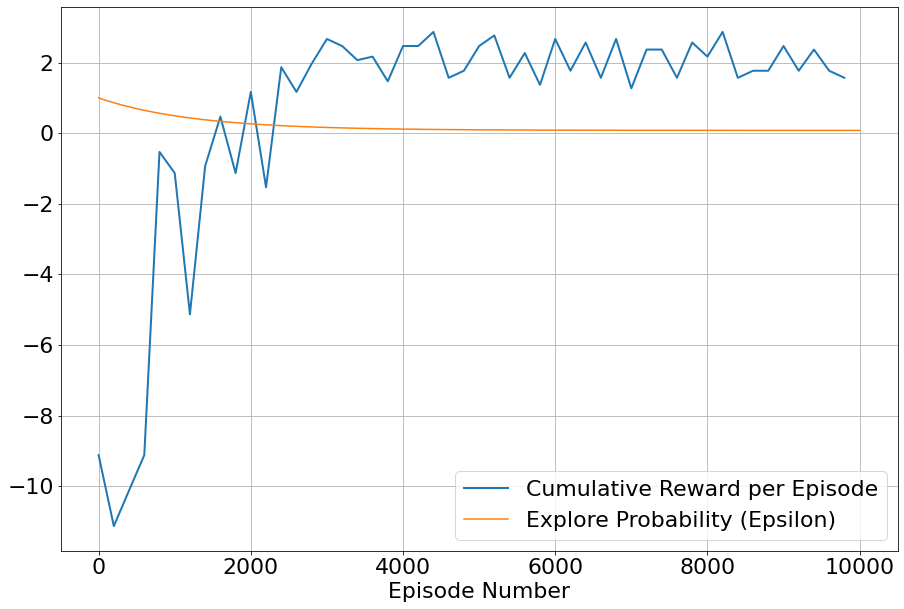

In [10]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [11]:
num_eval_episodes = 10**3
ev_q_history = qtrainer.evaluate(num_episodes=num_eval_episodes)

Eval Episode: 100%|██████████| 1000/1000 [00:01<00:00, 859.11it/s]


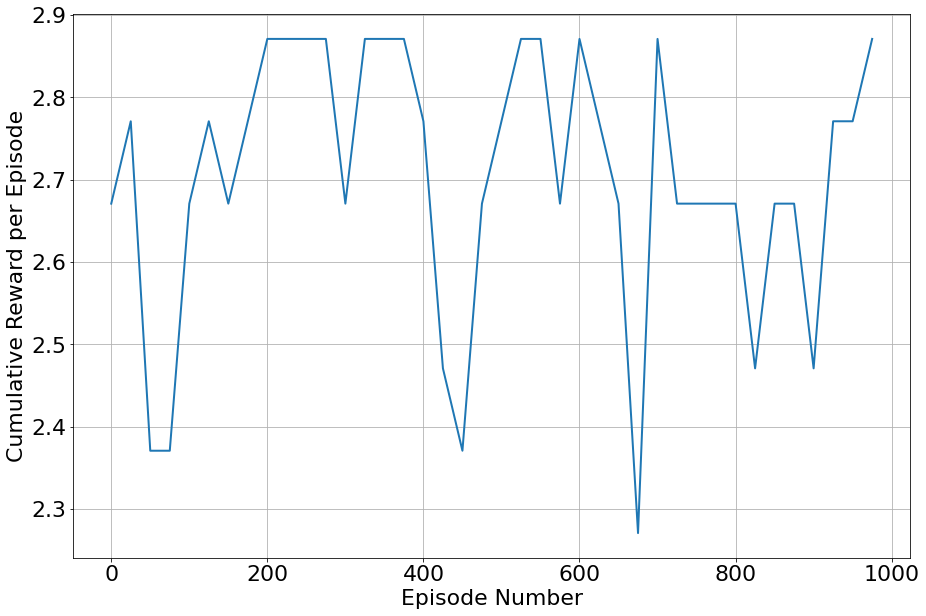

In [12]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_q_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [16]:
# learned_policy = [denv._action_to_direction[qlearning_agent.q_table[i].argmax()]['name']
#                   for i in range(qlearning_agent.q_table.shape[0])]


# learned_policy = np.array(learned_policy).reshape((denv.size, denv.size))

# print(learned_policy)

### Take the env for a spin

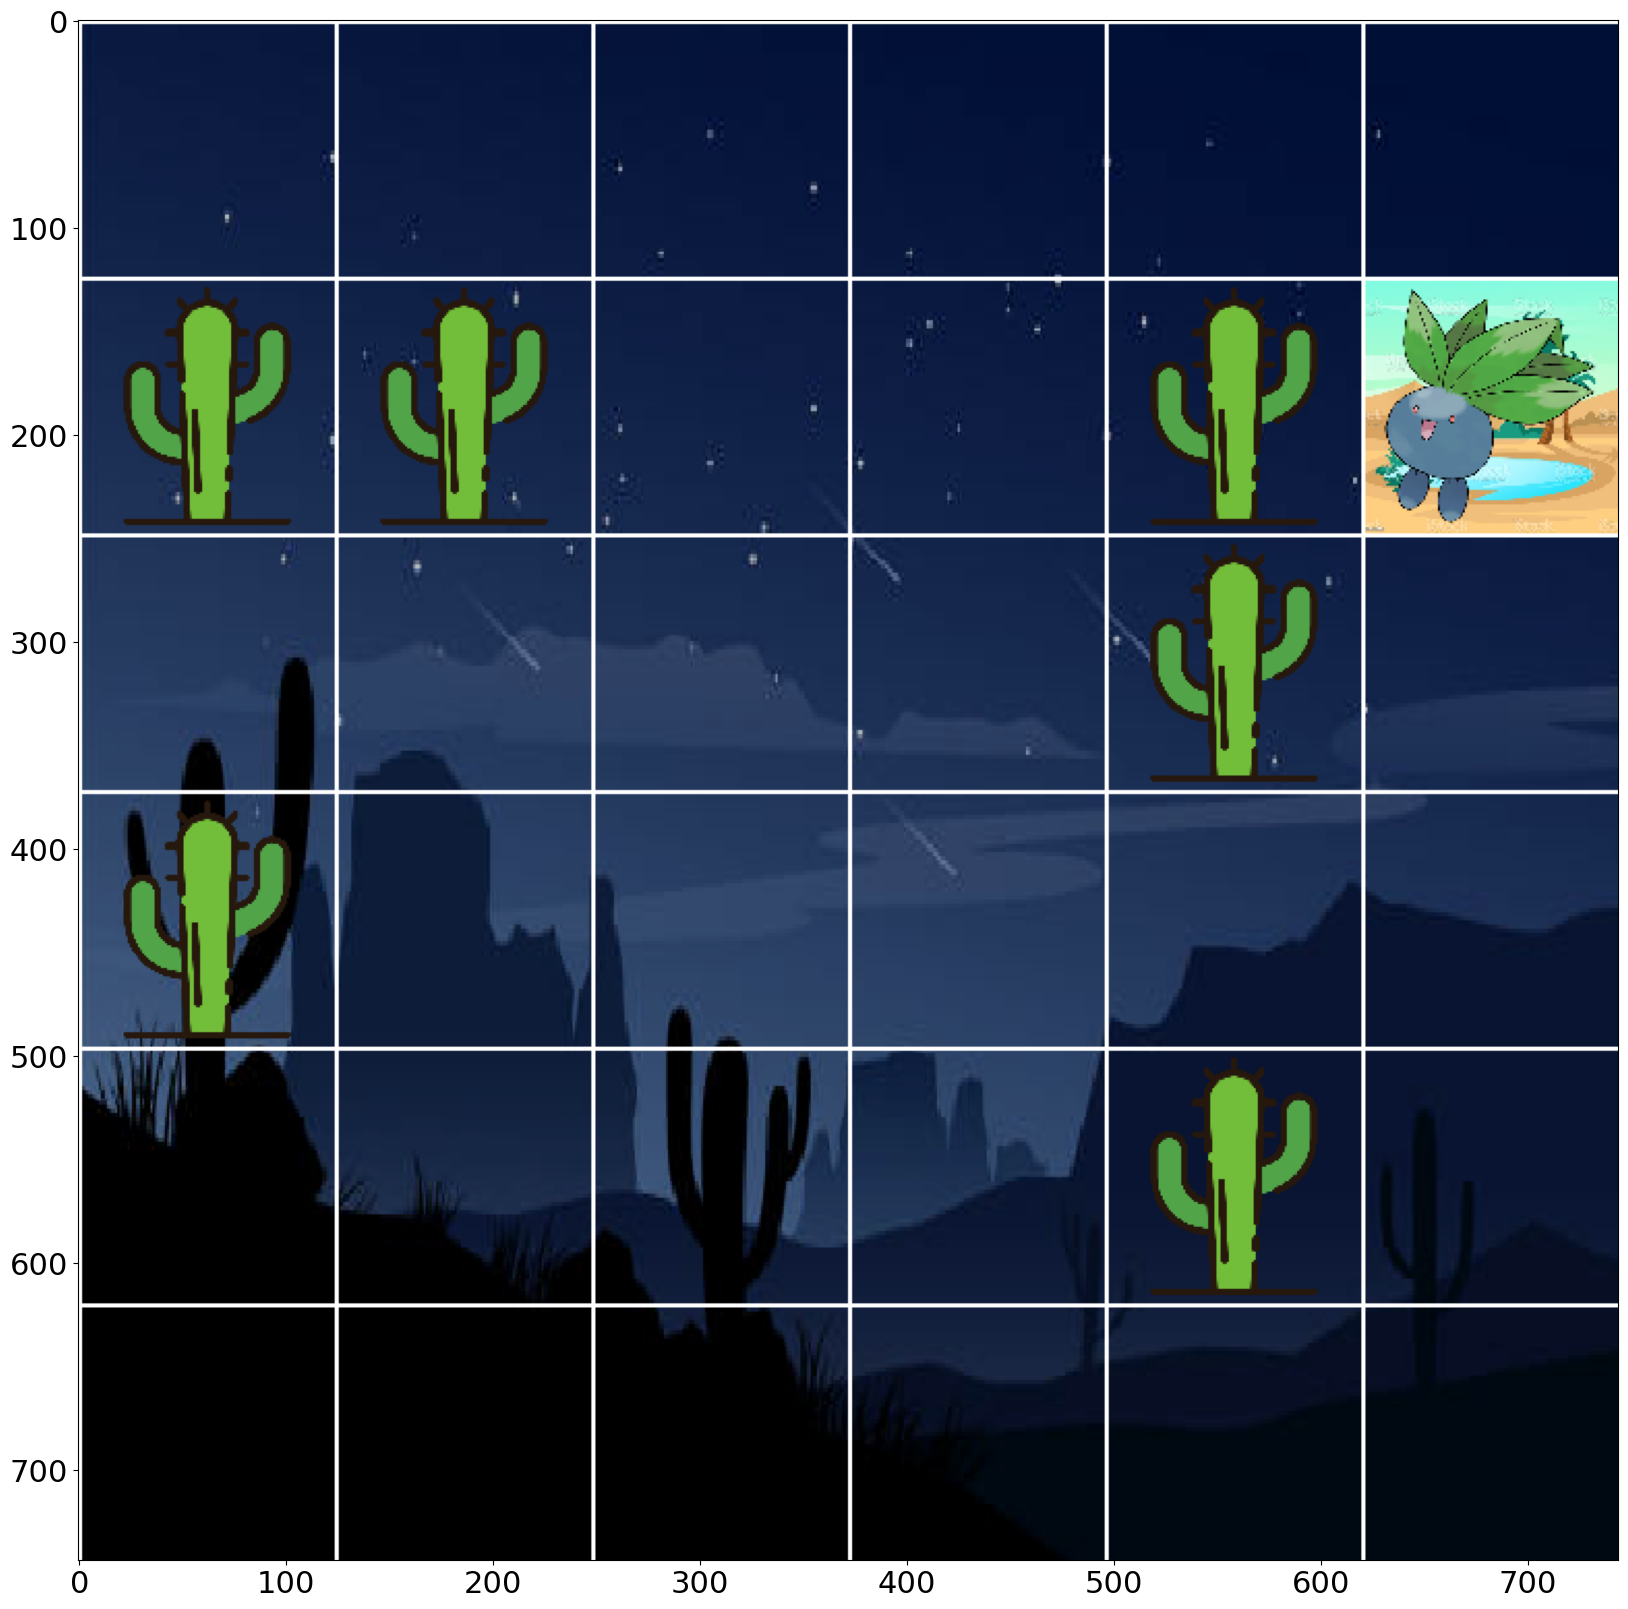

In [17]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22


episode_reward = 0
obs, info = denv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(denv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = qlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = denv.step(action)

  clear_output(wait=True)
  plt.imshow(denv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  episode_reward += reward
  time.sleep(1)

In [18]:
print(f"TOTAL REWARD: {episode_reward}")
# End the simulation
for item in ep_history:
    print(item)

denv.close()

TOTAL REWARD: 2.8707031249999995
({'agent': array([4, 3]), 'goal': array([1, 5])}, {'distance': 5.0})
({'agent': array([5, 3]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'down'}, 0.890234375)
({'agent': array([5, 2]), 'goal': array([1, 5])}, {'distance': 7.0, 'action': 'left'}, -0.1)
({'agent': array([5, 1]), 'goal': array([1, 5])}, {'distance': 8.0, 'action': 'left'}, 0.890234375)
({'agent': array([4, 1]), 'goal': array([1, 5])}, {'distance': 7.0, 'action': 'up'}, -0.1)
({'agent': array([3, 1]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'up'}, 0.890234375)
({'agent': array([3, 2]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'right'}, -0.1)
({'agent': array([3, 3]), 'goal': array([1, 5])}, {'distance': 4.0, 'action': 'right'}, -0.1)
({'agent': array([3, 4]), 'goal': array([1, 5])}, {'distance': 3.0, 'action': 'right'}, -0.1)
({'agent': array([3, 5]), 'goal': array([1, 5])}, {'distance': 2.0, 'action': 'right'}, -0.1)
({'agent': array([2, 5]), 'goal': array(

## Train the Double Q-Learning Agent

In [13]:
num_episodes = 10**4
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

dqlearning_agent = QLearningAgent(denv, dynamic=True, doubleq=True)
dqtrainer = DoubleQTrainer(dqlearning_agent)
tr_dq_history = dqtrainer.train(num_episodes=num_episodes, gamma=gamma)

Train Episode: 100%|██████████| 10000/10000 [00:26<00:00, 381.95it/s]


In [20]:
dqlearning_agent.q_table.shape

(2, 36864, 4)

In [21]:
# Save the Q Table
dqlearning_agent.save_pretrained('./doubleq-table-det.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# dqlearning_agent.q_table = './doubleq-table-det.pkl'

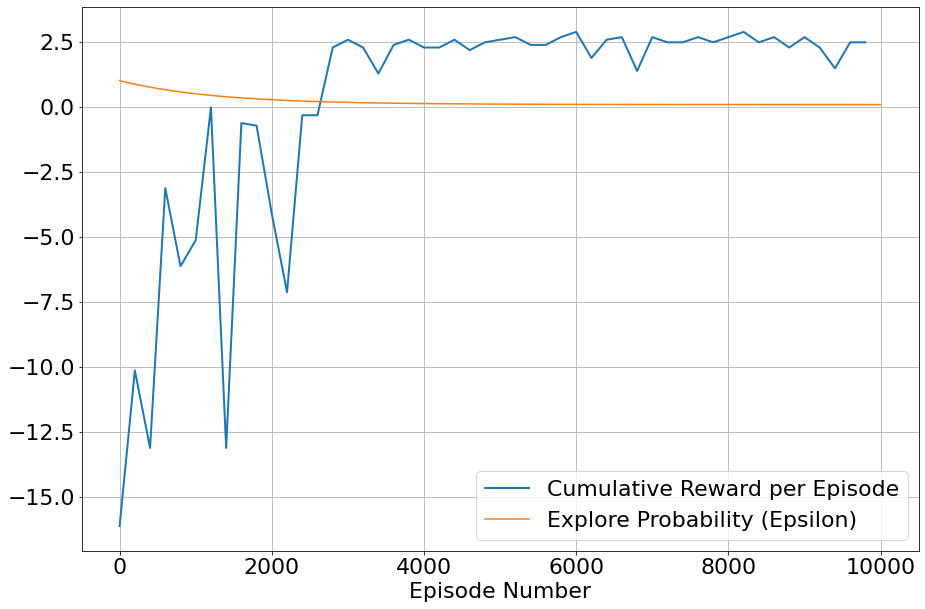

In [14]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [15]:
num_eval_episodes = 10**3
ev_dq_history = dqtrainer.evaluate(num_episodes=num_eval_episodes)

Eval Episode: 100%|██████████| 1000/1000 [00:01<00:00, 646.82it/s]


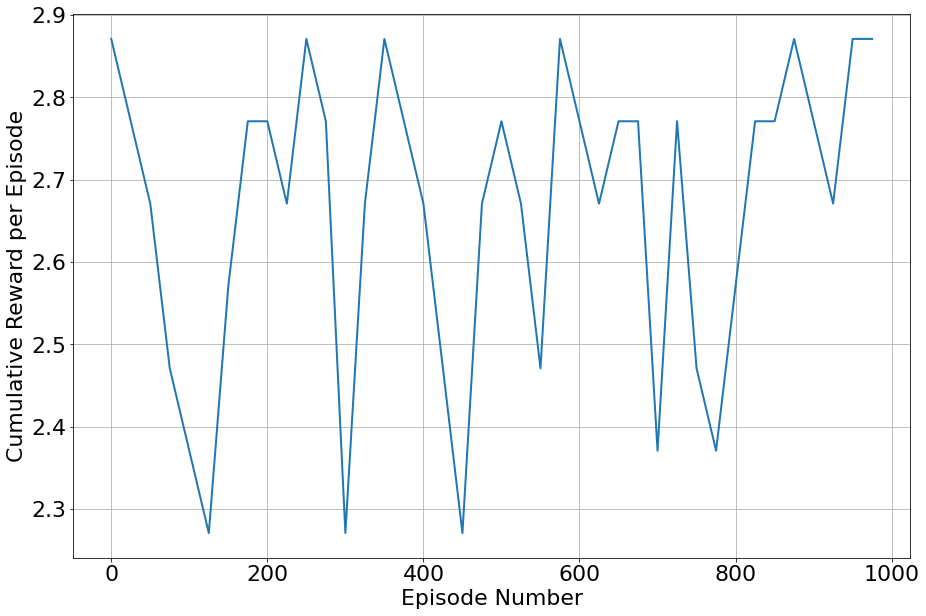

In [16]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_dq_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [25]:
# Take the mean of each states action-value estimates
# mean_q_table =  dqlearning_agent.q_table.mean(axis=0)
# learned_policy = [denv._action_to_direction[mean_q_table[i].argmax()]['name']
#                   for i in range(mean_q_table.shape[0])]


# learned_policy = np.array(learned_policy).reshape((denv.size, denv.size))

# print(learned_policy)

### Take the env for a spin

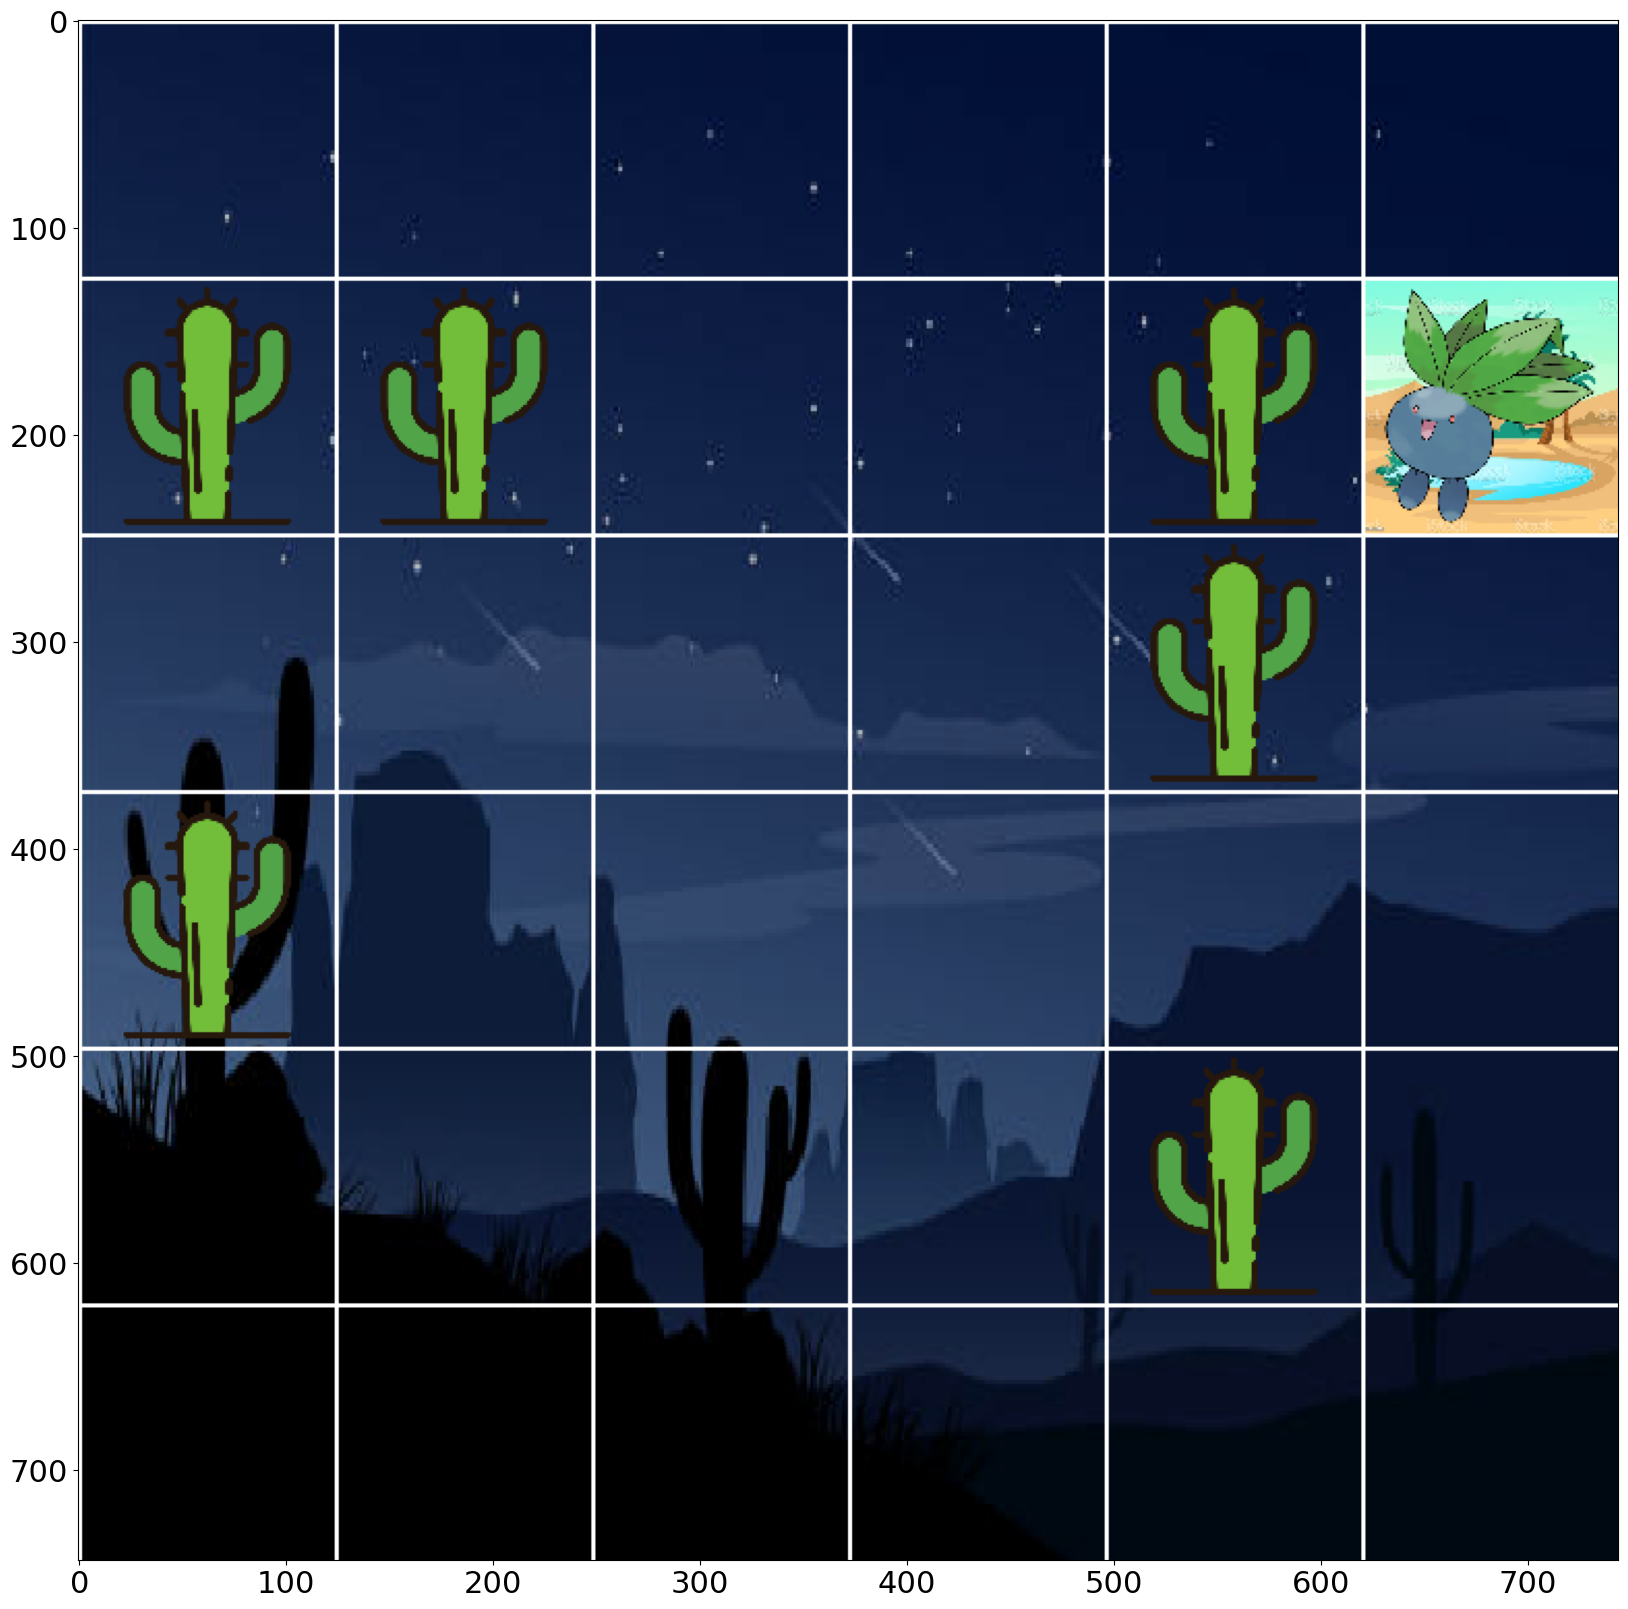

In [26]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22


episode_reward = 0
obs, info = denv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(denv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = dqlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = denv.step(action)

  clear_output(wait=True)
  plt.imshow(denv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  episode_reward += reward
  time.sleep(1)

In [27]:
print(f'TOTOAL REWARD: {episode_reward}')

# End the simulation
for item in ep_history:
    print(item)

denv.close()

TOTOAL REWARD: 2.7707031249999994
({'agent': array([5, 5]), 'goal': array([1, 5])}, {'distance': 4.0})
({'agent': array([5, 4]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'left'}, -0.1)
({'agent': array([5, 3]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'left'}, 0.890234375)
({'agent': array([5, 2]), 'goal': array([1, 5])}, {'distance': 7.0, 'action': 'left'}, -0.1)
({'agent': array([5, 1]), 'goal': array([1, 5])}, {'distance': 8.0, 'action': 'left'}, 0.890234375)
({'agent': array([4, 1]), 'goal': array([1, 5])}, {'distance': 7.0, 'action': 'up'}, -0.1)
({'agent': array([3, 1]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'up'}, 0.890234375)
({'agent': array([3, 2]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'right'}, -0.1)
({'agent': array([3, 3]), 'goal': array([1, 5])}, {'distance': 4.0, 'action': 'right'}, -0.1)
({'agent': array([3, 4]), 'goal': array([1, 5])}, {'distance': 3.0, 'action': 'right'}, -0.1)
({'agent': array([3, 5]), 'goal': array(

## Training Performance Evaluation

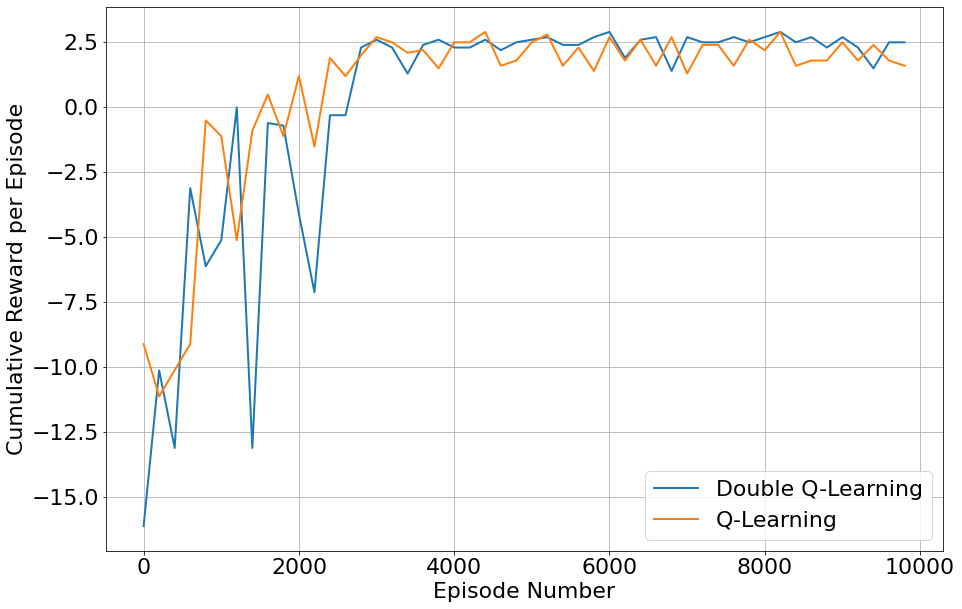

In [17]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Double Q-Learning', linewidth=2)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Q-Learning', linewidth=2)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward per Episode")
plt.grid(True)
plt.legend()

## Build a Stochastic Grid Env

### Rules:
- For every action there is a 2/3rd chance that the action is performed as expected (as-is),
a 2/9th chance that it is the double of what is expected and a 1/9th chance of it being a
mirror action.
- A bonus is distributed in a reciprocal proportions. i.e. 0.1x the max_reward for coming
through the as-is action, 0.2x max_reward for coming via the double action and
0.3x max_reward for the mirror action.

For instance on a 6x6 grid where the reward on each square is 1 (for simplicity):

If `s = (2,3)` and `a = RIGHT`:
-   2/3rd chance `s' = (2,4)` and `r = 1+0.1`
-   2/9th chance `s' = (2,5)` and `r = 1+0.2`
-   2/9th chance `s' = (3,2)` and `r = 1+0.3`

Exception: Landing on the `goal` square will always yield a maximal reward (of 1 for the above example) regardless of how you get there.

In [34]:
class StocasticGridEnvironment(Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "background_img": "./assets/background.jpg",
        "goal_img": "./assets/goal.png",
        "agent_img": "./assets/agent.png",
        "reward_img": "./assets/reward.png",
        "neg_reward_img": "./assets/neg_reward.png" 
    }

    def __init__(
        self,
        size: int = 4,
        max_time_steps:int = 20,
        render_mode=None,
        seed=88
    ):
        super().reset(seed=seed)
        self.size = size
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                "goal": spaces.Box(0, size - 1, shape=(2, ), seed=self.np_random, dtype=int),
                "reward": spaces.Box(
                    -1., 1.,
                    shape=(size**2, ),
                    seed=self.np_random,
                    dtype=np.float16
                )
            }
        )

        self.action_space = spaces.Discrete(4)
        self.action_mode_space = spaces.Discrete(3)
        self.max_timesteps = max_time_steps

        self._base_states = np.zeros((size, size), dtype=np.float16)

        # Add 6 negative rewards
        for _ in range(6):
            neg_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(neg_reward_loc)] != 0:
                neg_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(neg_reward_loc)] = self.observation_space['reward'].low[0]

        # Add 3 positive rewards
        for _ in range(3):
            pos_reward_loc = self.observation_space['agent'].sample()
            while self._base_states[tuple(pos_reward_loc)] != 0:
                pos_reward_loc = self.observation_space['agent'].sample()

            self._base_states[tuple(pos_reward_loc)] = \
                .99 * self.observation_space['reward'].high[0]

        """The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: {'move': np.array([1, 0]), 'name': 'down'},
            1: {'move': np.array([-1, 0]), 'name': 'up'},
            2: {'move': np.array([0, 1]), 'name': 'right'},
            3: {'move': np.array([0, -1]), 'name': 'left'},
        }
        self._action_mode_mapping = {
            0: {'p': 2/3, 'name': 'as-is', 'score_mul': 1},
            1: {'p': 2/9, 'name': 'double', 'score_mul': 2},
            2: {'p': 1/9, 'name': 'mirror', 'score_mul': 3}
        }

        self.timestep = 0
        self.states = self._base_states.copy()
        # We will sample the goals's location randomly until it does not coincide
        # with the reward locations.
        self._goal_pos = self.observation_space['goal'].sample()
        while self.states[tuple(self._goal_pos)] != 0:
            self._goal_pos = self.observation_space['goal'].sample()

        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # We will sample the agent's location randomly until it does not coincide
        # with the goal and reward locations.
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        # Check for render mode legality
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        self.window_size = 744  # The size of the PyGame window

    def reset(self, seed=None, options=None):
        # For compliance
        super().reset(seed=seed)

        # Reset env
        self.timestep = 0
        self.states = self._base_states.copy()
        self.states[tuple(self._goal_pos)] = self.observation_space['reward'].high[0]

        # Agent start pos changes everytime
        self._agent_pos = self.observation_space['agent'].sample()
        while self.states[tuple(self._agent_pos)] != 0:
            self._agent_pos = self.observation_space['agent'].sample()

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Randomly select the action mode
        action_mode = self.np_random.choice(
            range(self.action_mode_space.n),
            p=[self._action_mode_mapping[i]['p']
               for i in range(self.action_mode_space.n)]
        )

        if self._action_mode_mapping[action_mode]['name'] in ('double', 'as-is'):
            direction = self._action_to_direction[action]['move'].copy()
            if self._action_mode_mapping[action_mode]['name'] == 'double':
                direction *= 2

            # Restricting the agent to the grid.
            new_pos = np.clip(
                self._agent_pos + direction,
                0, self.size - 1
            )

        else:
            new_pos = self._agent_pos[::-1]

        # Penalize reaching the goal before collecting all rewards
        block_exit = (self.states > 0).sum() > 1

        terminated = False
        if np.array_equal(new_pos, self._goal_pos):
            if block_exit:
                new_pos = self._agent_pos
            else:
                terminated = True

        # Calculate base bonus
        base_bonus = (self.states[tuple(new_pos)]>0) * \
            .1 * self.observation_space['reward'].high[0]

        # Give negative reward for actions that keep you in the same
        # place (boundary actions)
        if np.array_equal(self._agent_pos, new_pos):
            reward = self.observation_space['reward'].low[0]
        else:
            reward = self.states[tuple(new_pos)] + base_bonus * \
                self._action_mode_mapping[action_mode]['score_mul']

        # In all cases add a reward penalty of 0.1 * max_negative_reward
        # in other words, every action is penalized.
        reward += .1 * self.observation_space['reward'].low[0]

        self._agent_pos = new_pos

        # Record the action taken
        observation = self._get_obs()

        # Consume reward
        self.states[tuple(self._agent_pos)] = 0
        
        # An episode is done iff the agent has reached the goal
        self.timestep += 1

        truncated = self.timestep > self.max_timesteps

        info = self._get_info()
        info.update({
            'action': self._action_to_direction[action]['name'],
            'action_mode': self._action_mode_mapping[action_mode]['name']
        })

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        return {
            "agent": self._agent_pos,
            "goal": self._goal_pos,
            "reward": self.states.flatten()
        }

    # City block distance between goal and agent
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_pos - self._goal_pos, ord=1
            )
        }

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Background image
        bg_img = pygame.image.load(self.metadata['background_img'])
        bg_img.set_alpha(188)
        bg_img = pygame.transform.scale(bg_img, (self.window_size, self.window_size))
        canvas.blit(
            bg_img,
            [0, 0]
        )

        # Goal image
        goal_img = pygame.image.load(self.metadata['goal_img'])
        goal_img = pygame.transform.scale(goal_img, (pix_square_size, pix_square_size))
        canvas.blit(
            goal_img,
            pix_square_size * self._goal_pos[::-1]
        )

        # Agent image
        agent_img = pygame.image.load(self.metadata['agent_img'])
        agent_img = pygame.transform.scale(agent_img, (pix_square_size, pix_square_size))
        canvas.blit(
            agent_img,
            pix_square_size * self._agent_pos[::-1]
        )

        # Reward image
        reward_img = pygame.image.load(self.metadata['reward_img'])
        # Negative reward image
        neg_reward_img = pygame.image.load(self.metadata['neg_reward_img'])

        # Add the reward and neg reward
        for x in range(self.size):
            for y in range(self.size):
                reward = self.states[x, y]
                if self.states[x, y] > 0 and self.states[x, y] < \
                    self.observation_space['reward'].high[0]:
                    sreward_img = pygame.transform.scale(
                        reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    rew_sz = np.array(sreward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= rew_sz[::-1] / 2
                    canvas.blit(
                        sreward_img,
                        position
                    )
                elif self.states[x, y] < 0:
                    reward *= -1
                    sneg_reward_img = pygame.transform.scale(
                        neg_reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    nrew_sz = np.array(sneg_reward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= nrew_sz[::-1] / 2
                    canvas.blit(
                        sneg_reward_img,
                        position
                    )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=2,
            )
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=2,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [35]:
# Initialize the agent and the env
senv = StocasticGridEnvironment(size=6, render_mode='rgb_array', max_time_steps=40)

# Check for API Compliance
env_checker.check_env(senv)

## Train the Q-Learning Agent

In [20]:
num_episodes = 10**5
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

qlearning_agent = QLearningAgent(senv, dynamic=True)
qtrainer = QLearningTrainer(qlearning_agent)
tr_q_history = qtrainer.train(num_episodes=num_episodes, gamma=gamma)

Train Episode: 100%|██████████| 100000/100000 [04:05<00:00, 407.01it/s]


In [37]:
# Save the Q Table
# qlearning_agent.save_pretrained('./q-table-sto.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
qlearning_agent.q_table = './q-table-sto.pkl'

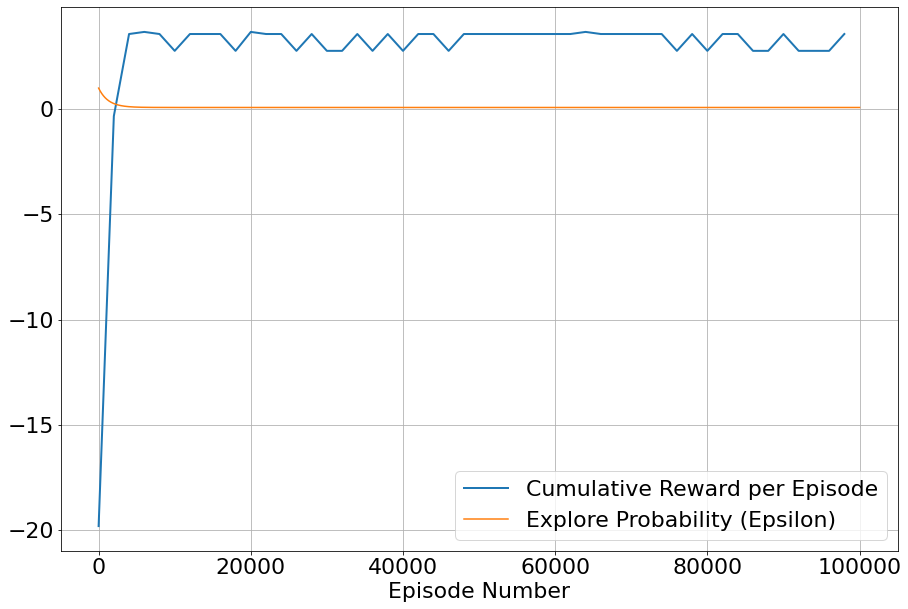

In [21]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [22]:
num_eval_episodes = 10**3
ev_q_history = qtrainer.evaluate(num_episodes=num_eval_episodes)

Eval Episode: 100%|██████████| 1000/1000 [00:02<00:00, 344.12it/s]


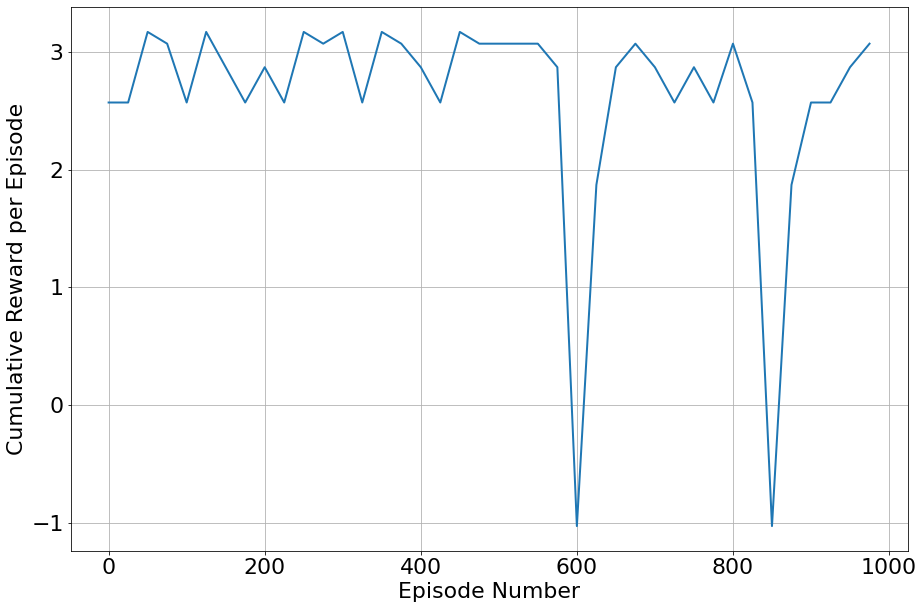

In [23]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_q_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [36]:
# learned_policy = [senv._action_to_direction[qlearning_agent.q_table[i].argmax()]['name']
#                   for i in range(qlearning_agent.q_table.shape[0])]


# learned_policy = np.array(learned_policy).reshape((senv.size, senv.size))

# print(learned_policy)

### Take the env for a spin

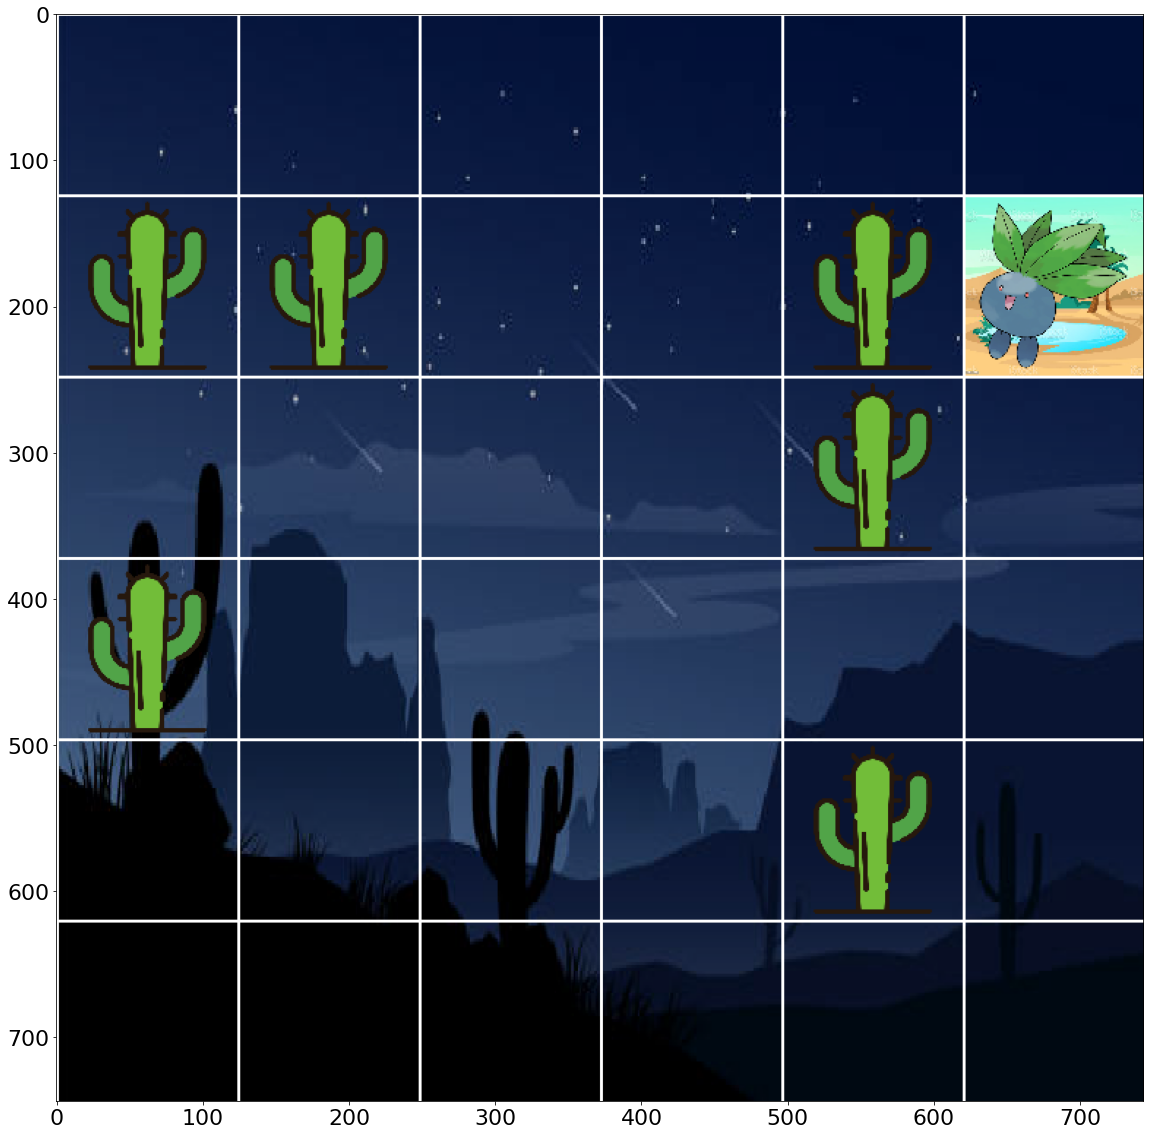

In [39]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22


episode_reward = 0
obs, info = senv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(senv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = qlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = senv.step(action)

  clear_output(wait=True)
  plt.imshow(senv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  episode_reward += reward
  time.sleep(1)

In [38]:
print(f'TOTOAL REWARD: {episode_reward}')

# End the simulation
for item in ep_history:
    print(item)

senv.close()

TOTOAL REWARD: 3.170703124999999
({'agent': array([2, 3]), 'goal': array([1, 5])}, {'distance': 3.0})
({'agent': array([3, 3]), 'goal': array([1, 5])}, {'distance': 4.0, 'action': 'down', 'action_mode': 'as-is'}, -0.1)
({'agent': array([5, 3]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'down', 'action_mode': 'double'}, 1.0902343749999999)
({'agent': array([5, 1]), 'goal': array([1, 5])}, {'distance': 8.0, 'action': 'left', 'action_mode': 'double'}, 1.0902343749999999)
({'agent': array([5, 3]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'right', 'action_mode': 'double'}, -0.1)
({'agent': array([4, 3]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'up', 'action_mode': 'as-is'}, -0.1)
({'agent': array([3, 3]), 'goal': array([1, 5])}, {'distance': 4.0, 'action': 'up', 'action_mode': 'as-is'}, -0.1)
({'agent': array([3, 2]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'left', 'action_mode': 'as-is'}, -0.1)
({'agent': array([3, 1]), 'goal': array([1, 5])}, {

## Train the Double Q-Learning Agent

In [24]:
num_episodes = 10**5
lr = .4
gamma = 0.95
ep_min = .08
ep_max = 1.
decay_rate = 8e-4

dqlearning_agent = QLearningAgent(senv, dynamic=True, doubleq=True)
dqtrainer = DoubleQTrainer(dqlearning_agent)
tr_dq_history = dqtrainer.train(num_episodes=num_episodes, gamma=gamma)

Train Episode: 100%|██████████| 100000/100000 [04:37<00:00, 360.58it/s]


In [40]:
# Save the Q Table
dqlearning_agent.save_pretrained('./doubleq-table-sto.pkl')

# The q table can be loaded from the pkl file by uncommenting the below line
# dqlearning_agent.q_table = './doubleq-table-sto.pkl'

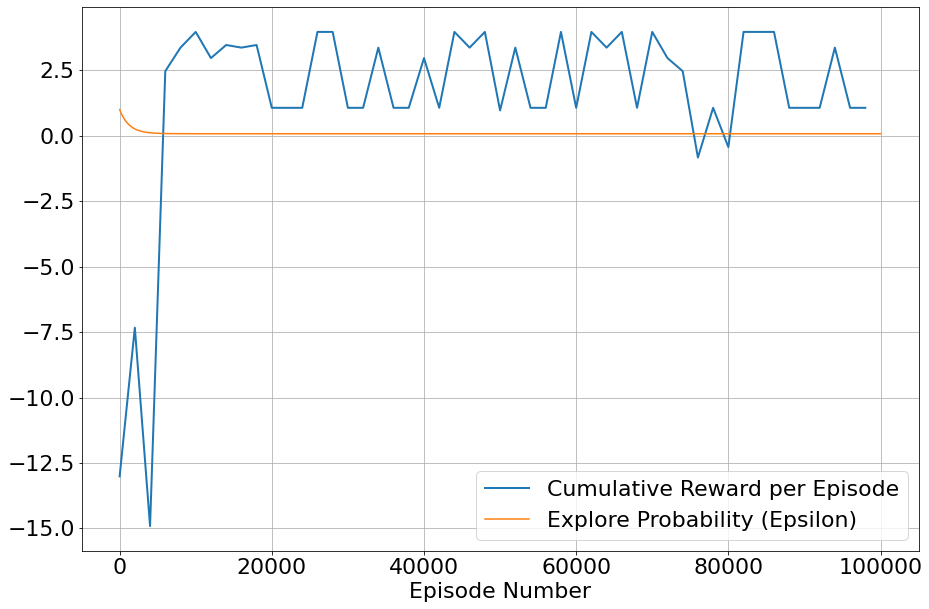

In [25]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Cumulative Reward per Episode', linewidth=2)
plt.plot([ep_min+(ep_max-ep_min)*np.exp(-decay_rate*i) for i in range(num_episodes)], label='Explore Probability (Epsilon)')
plt.xlabel("Episode Number")
plt.grid(True)
plt.legend()
plt.show()

### Evaluate the Agent

In [26]:
num_eval_episodes = 10**3
ev_dq_history = dqtrainer.evaluate(num_episodes=num_eval_episodes)

Eval Episode: 100%|██████████| 1000/1000 [00:04<00:00, 220.60it/s]


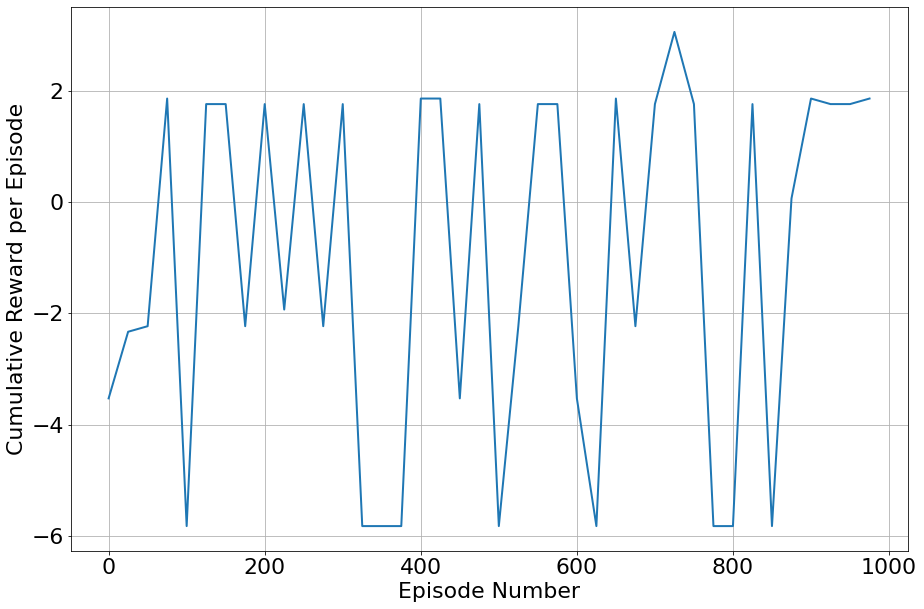

In [27]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 22

plt.plot(range(0, num_eval_episodes, 25), ev_dq_history[::25],  linewidth=2)
plt.ylabel('Cumulative Reward per Episode')
plt.xlabel("Episode Number")
plt.grid(True)
plt.show()

### Display Learned Policy

In [44]:
# Take the mean of each states action-value estimates
# mean_q_table =  dqlearning_agent.q_table.mean(axis=0)
# learned_policy = [senv._action_to_direction[mean_q_table[i].argmax()]['name']
#                   for i in range(mean_q_table.shape[0])]


# learned_policy = np.array(learned_policy).reshape((senv.size, senv.size))

# print(learned_policy)

### Take the env for a spin

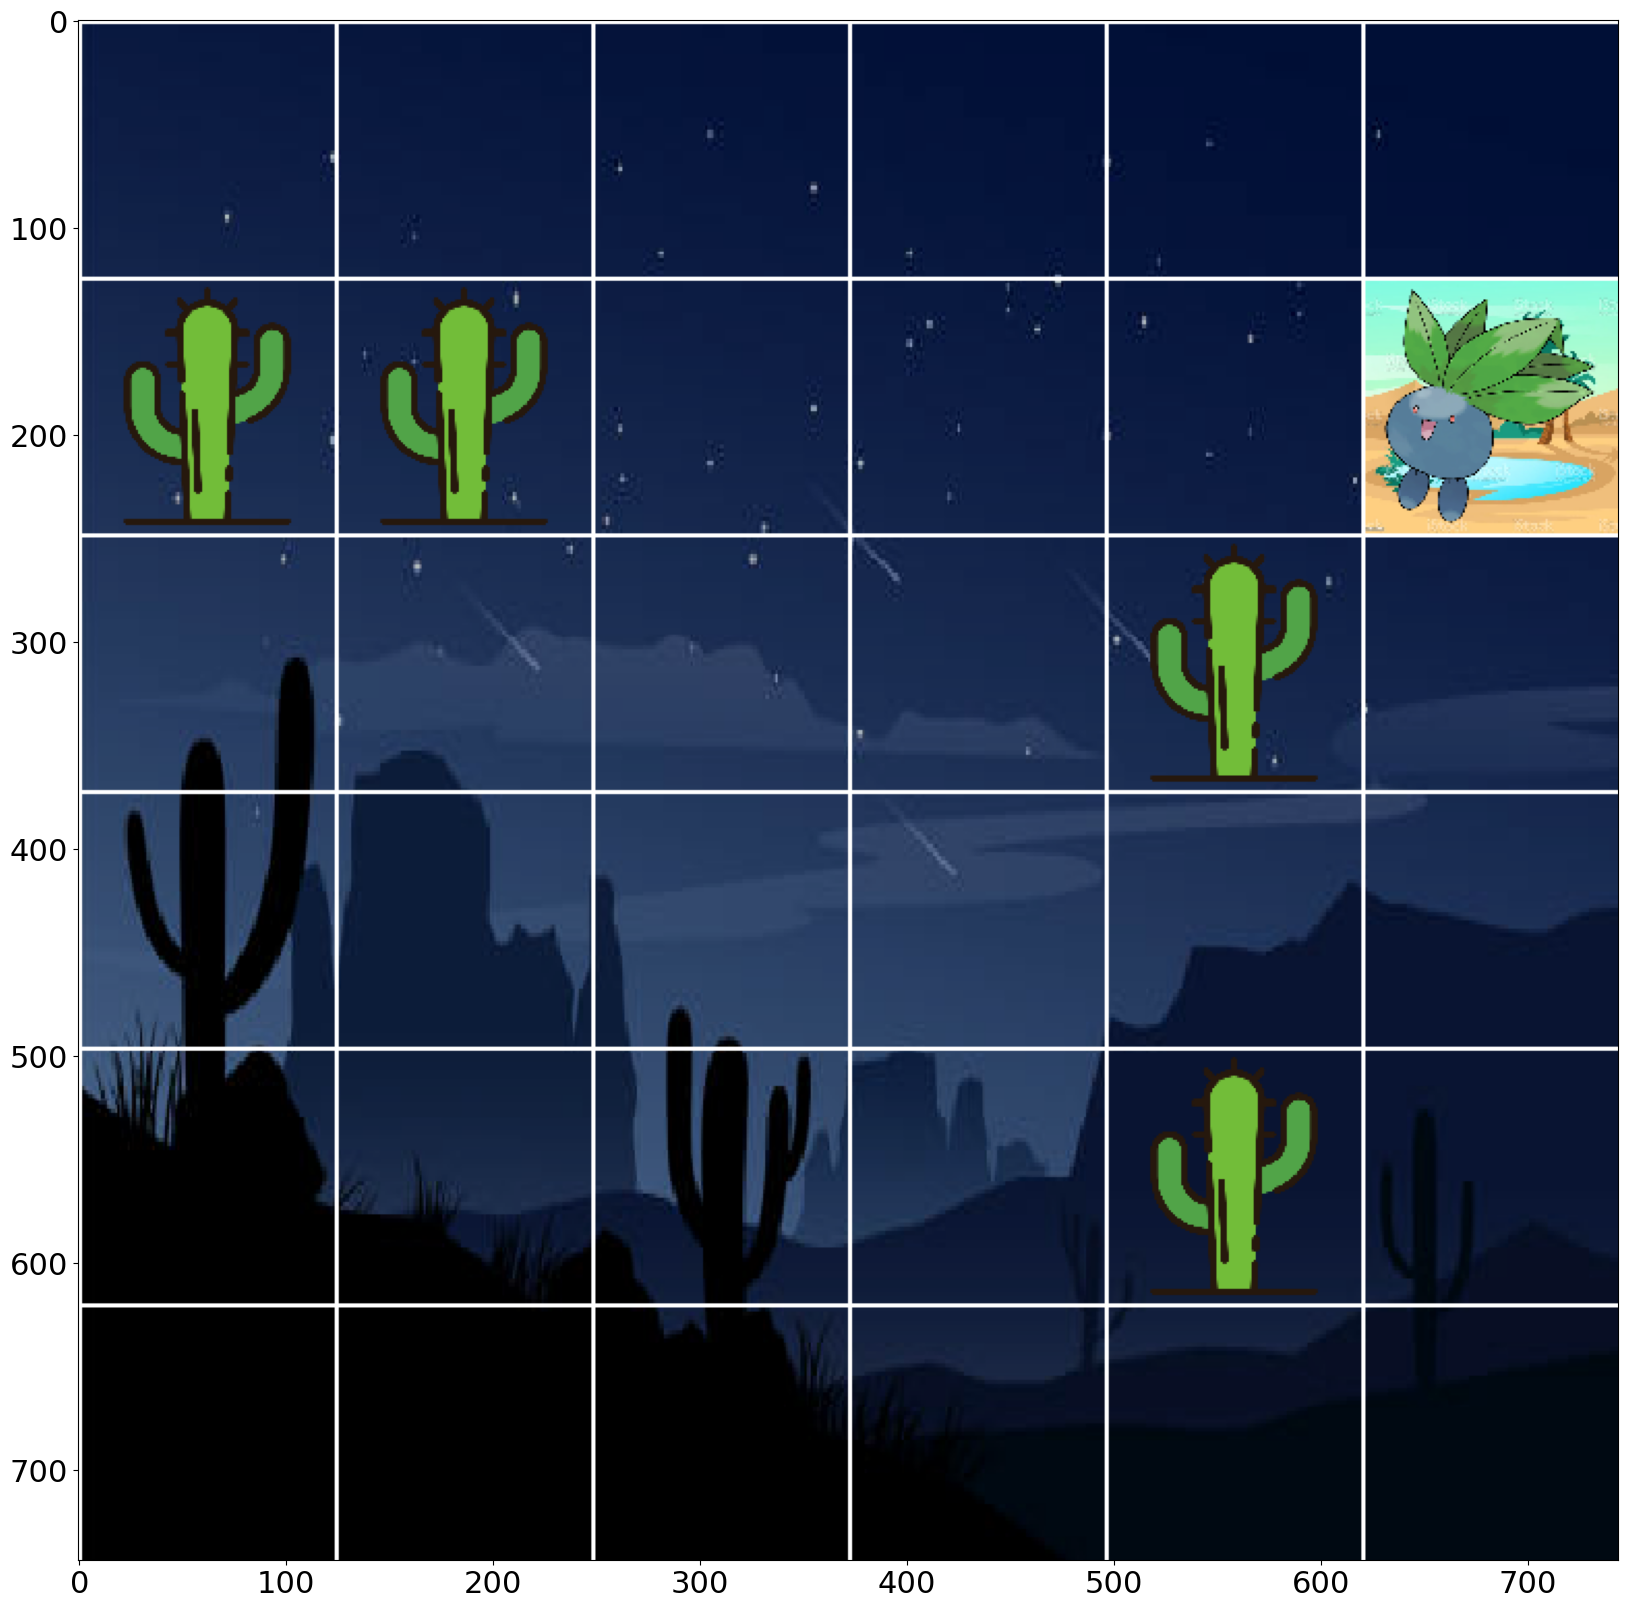

In [45]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams["font.size"] = 22


episode_reward = 0
obs, info = senv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(senv.render())
plt.show()

ep_history = [({k: obs[k] for k in set(list(obs.keys())) - {'reward'}}, info)]
while not (terminated or truncated):
  action = dqlearning_agent.step(obs)
  obs, reward, terminated, truncated, info = senv.step(action)

  clear_output(wait=True)
  plt.imshow(senv.render())
  plt.show()

  ep_history.append((
    {k: obs[k] for k in set(list(obs.keys())) - {'reward'}},
    info, reward))
  episode_reward += reward
  time.sleep(1)

In [46]:
print(f'TOTOAL REWARD: {episode_reward}')

# End the simulation
for item in ep_history:
    print(item)

senv.close()

TOTOAL REWARD: 0.5707031250000001
({'agent': array([2, 2]), 'goal': array([1, 5])}, {'distance': 4.0})
({'agent': array([3, 2]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'down', 'action_mode': 'as-is'}, -0.1)
({'agent': array([3, 4]), 'goal': array([1, 5])}, {'distance': 3.0, 'action': 'right', 'action_mode': 'double'}, -0.1)
({'agent': array([3, 2]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'left', 'action_mode': 'double'}, -0.1)
({'agent': array([3, 4]), 'goal': array([1, 5])}, {'distance': 3.0, 'action': 'right', 'action_mode': 'double'}, -0.1)
({'agent': array([3, 3]), 'goal': array([1, 5])}, {'distance': 4.0, 'action': 'left', 'action_mode': 'as-is'}, -0.1)
({'agent': array([4, 3]), 'goal': array([1, 5])}, {'distance': 5.0, 'action': 'down', 'action_mode': 'as-is'}, -0.1)
({'agent': array([5, 3]), 'goal': array([1, 5])}, {'distance': 6.0, 'action': 'down', 'action_mode': 'as-is'}, 0.9902343750000001)
({'agent': array([5, 2]), 'goal': array([1, 5])}, {'distanc

## Training Performance Evaluation

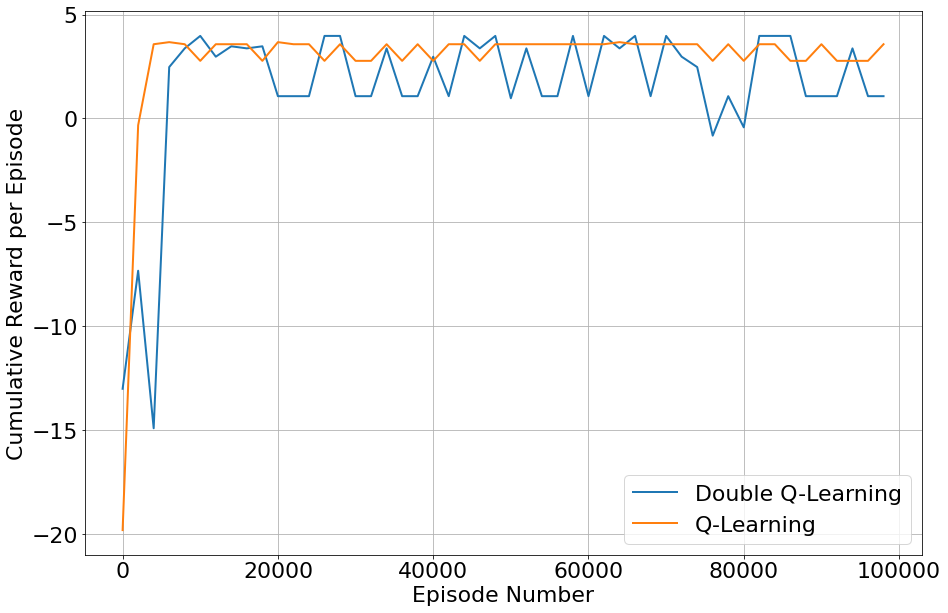

In [29]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["font.size"] = 22

step = int(num_episodes/50)
plt.plot(range(0, num_episodes, step), tr_dq_history[::step], label='Double Q-Learning', linewidth=2)
plt.plot(range(0, num_episodes, step), tr_q_history[::step], label='Q-Learning', linewidth=2)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward per Episode")
plt.grid(True)
plt.legend()

## Hyper parameter tuning

In [ ]:
import optuna

AGENT = QLearningAgent(denv, dynamic=True)

def objective(trial):
    gamma = trial.suggest_float('gamma', .80, .99)
    lr = trial.suggest_float('lr', .1, .5)
    num_episodes = trial.suggest_int('num_episodes', 500, 10**3)

    AGENT.reset()
    qtrainer = QLearningTrainer(AGENT)
    qtrainer.train(num_episodes=num_episodes, gamma=gamma, lr=lr, quiet=True)
    
    return np.array(qtrainer.evaluate(num_episodes=100, quiet=True)).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True)

Indexing States: 100%|██████████| 36/36 [00:00<00:00, 55.11it/s]
[I 2023-03-02 01:32:59,936] A new study created in memory with name: no-name-2e110bd0-a4f3-4688-bb45-1c32d987094c
/projects/academic/courses/cse546s23/m44/anaconda3/lib/python3.10/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-03-02 01:33:06,390] Trial 0 finished with value: 2.6497031249999994 and parameters: {'gamma': 0.8259906259057088, 'lr': 0.22896984743811985, 'num_episodes': 827}. Best is trial 0 with value: 2.6497031249999994.
[I 2023-03-02 01:33:11,640] Trial 1 finished with value: 2.636703124999999 and parameters: {'gamma': 0.9818432936958058, 'lr': 0.4638858313402574, 'num_episodes': 648}. Best is trial 0 with value: 2.6497031249999994.
[I 2023-03-02 01:33:17,391] Trial 2 finished with value: -1.1292968750000008 and parameters: {'gamma': 0.8310903113645312, 'lr': 0.14527709246423176, 'num_episodes': 649}. Best is trial 0 with value: 2.6497031249999994.
[I 2023-03-02 01:33:22,574] Trial 3 finished with value: 0.8837031249999993 and parameters: {'gamma': 0.8754929935157182, 'lr': 0.2552824681003654, 'num_episodes': 597}. Best is trial 0 with value: 2.6497031249999994.
[I 2023-03-02 01:33:28,568] Trial 4 finished with value: -0.05129687500000099 and parameters: {'gamma': 0.8738147086399518, 'l

[I 2023-03-02 01:36:59,063] Trial 36 finished with value: -1.1292968750000008 and parameters: {'gamma': 0.8857726316190673, 'lr': 0.2612675426123914, 'num_episodes': 616}. Best is trial 26 with value: 2.6917031249999996.
[I 2023-03-02 01:37:05,505] Trial 37 finished with value: 2.6327031249999995 and parameters: {'gamma': 0.8449363901195087, 'lr': 0.21384946439784516, 'num_episodes': 759}. Best is trial 26 with value: 2.6917031249999996.
[I 2023-03-02 01:37:11,656] Trial 38 finished with value: 2.647703124999999 and parameters: {'gamma': 0.8754468810469179, 'lr': 0.48212605952080245, 'num_episodes': 767}. Best is trial 26 with value: 2.6917031249999996.
[I 2023-03-02 01:37:16,339] Trial 39 finished with value: -1.1292968750000008 and parameters: {'gamma': 0.9061068653742579, 'lr': 0.16487767439538256, 'num_episodes': 515}. Best is trial 26 with value: 2.6917031249999996.
[I 2023-03-02 01:37:23,219] Trial 40 finished with value: 2.669703125 and parameters: {'gamma': 0.9222538900371327, 

[I 2023-03-02 01:40:58,889] Trial 72 finished with value: 2.6627031249999993 and parameters: {'gamma': 0.9071771865662119, 'lr': 0.34996031076704476, 'num_episodes': 976}. Best is trial 53 with value: 2.696703124999999.


In [ ]:
study.best_trials